1. Connect to an Azure SQL database and retrieves distinct court booking data for the latest playwright test runID, utilizing environment variables for secure connection details. data frame captures  the most recent status for each date, which is final observed court state

In [4]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

# Retrieve connection details from environment variables
server = os.getenv("AZURE_SQL_SERVER")
database = os.getenv("AZURE_SQL_DATABASE")
username = os.getenv("AZURE_SQL_USER")
password = os.getenv("AZURE_SQL_PASSWORD")

# Define the connection string using SQLAlchemy format
conn_str = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# Create an SQLAlchemy engine
engine = create_engine(conn_str)

# Query the database
query = """
    WITH LatestRun AS (
    SELECT dateId, MAX(runId) AS maxRunId
    FROM CourtBookingLog
    GROUP BY dateId
)
SELECT DISTINCT cl.runId, cl.courtNumber, cl.dateId, cl.timeId, cl.p1, cl.p2, cl.p3, cl.p4 
FROM CourtBookingLog AS cl
JOIN LatestRun AS lr
ON cl.dateId = lr.dateId AND cl.runId = lr.maxRunId;


   
"""
# Read data into a DataFrame
df = pd.read_sql(query, engine)

# Close the engine connection
engine.dispose()


2.Use NetworkX to create a graph representing player played together Each edge in the graph represents two players who played together, with edge weights indicating the frequency of their playing together.

In [5]:
import networkx as nx
from itertools import combinations

# Initialize an empty graph
G = nx.Graph()

# Iterate through each row and add edges based on co-participation
for _, row in df.iterrows():
    # Collect players from the row, filtering out any NaN values
    players = [row['p1'], row['p2'], row['p3'], row['p4']]
    players = [p for p in players if pd.notna(p)]

    # Create edges for every pair of players who played together
    for player1, player2 in combinations(players, 2):
        if G.has_edge(player1, player2):
            # If the edge already exists, increment the weight by 1
            G[player1][player2]['weight'] += 1
        else:
            # If the edge doesn't exist, create it with an initial weight of 1
            G.add_edge(player1, player2, weight=1)

# Check if there are any edges in the graph
print("Number of edges in the graph:", G.number_of_edges())


Number of edges in the graph: 1629


3. Clustering analysis on weighted graph. Visualizes a player co-participation network with clustering, using the Louvain method to detect communities within the graph. 
Louvain clustering is a network analysis algorithm that identifies communities in large networks by maximizing modularity. Modularity is a measure of how well-connected nodes are within a community, compared to a random network. 

Each node represents a player, and each edge represents co-participation. Clusters are highlighted with different colors, and edge thickness reflects the frequency of player Plating together on same court.




C:\Users\rasingh.000\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


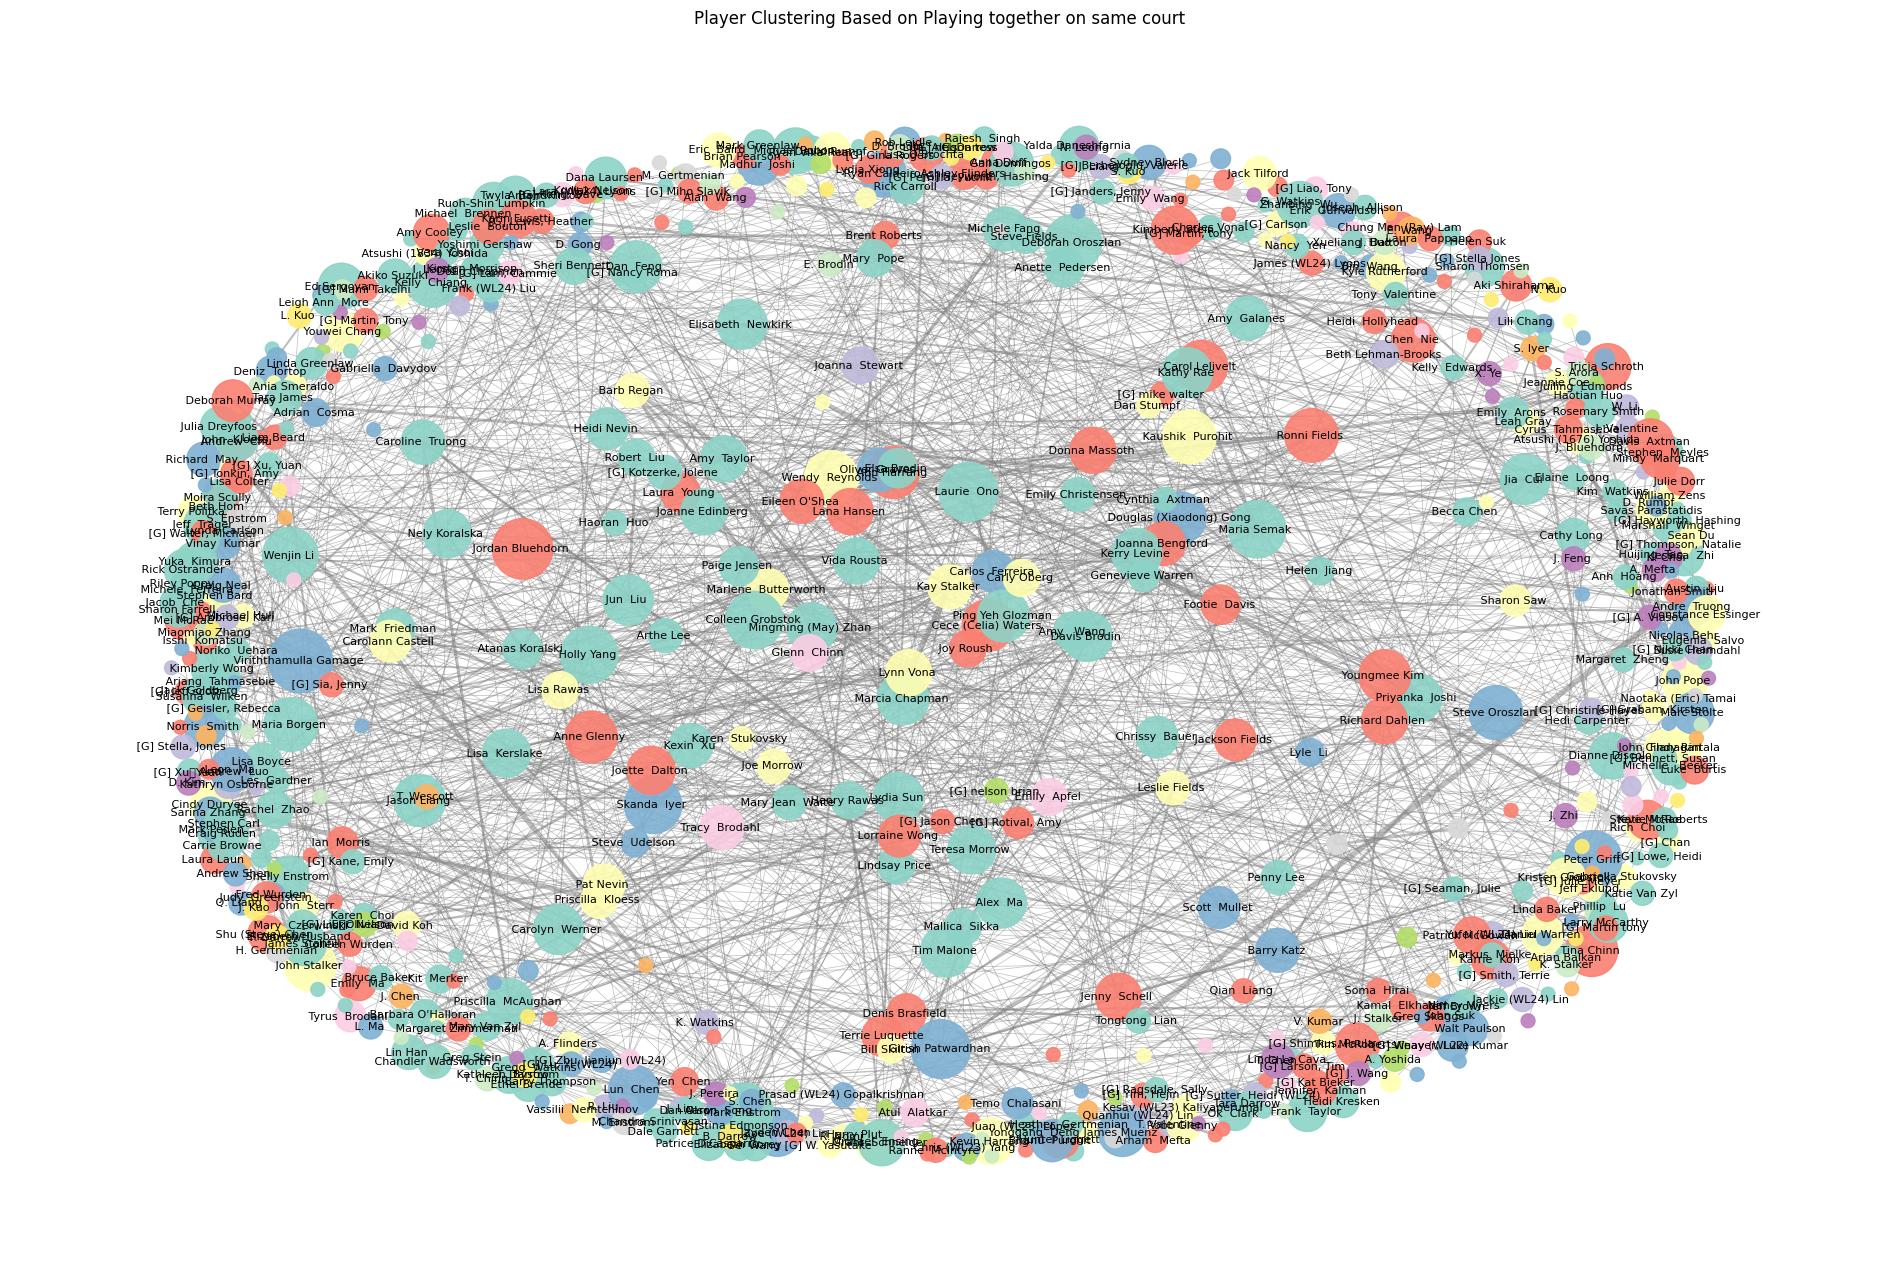

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from itertools import combinations
from matplotlib.cm import get_cmap  # Import colormap utility

# Assuming G is already created with nodes and edges
# Create graph G and apply clustering
partition = community_louvain.best_partition(G, weight='weight')

# Define layout with spacing adjustments
pos = nx.spring_layout(G, seed=42, k=1.0)

# Define node sizes and colors by cluster
node_sizes = [G.degree(node) * 100 for node in G]
clusters = [partition[node] for node in G]

plt.figure(figsize=(24, 16))

# Draw nodes, edges, and labels with better readability
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=clusters, cmap='Set3', alpha=0.9)  # Corrected: use 'Set3' as string

edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="grey")

important_labels = {node: node for node in G if G.degree(node) > 2}
nx.draw_networkx_labels(G, pos, labels=important_labels, font_size=8, font_color="black")

# Add title and legend
plt.title("Player Clustering Based on Playing together on same court")
plt.axis("off")
plt.show()


4. This did not highlight any colluding group. Create a graph that connects the court owner (p1) with each of the other players (p2, p3, and p4) to find any colluding clusters

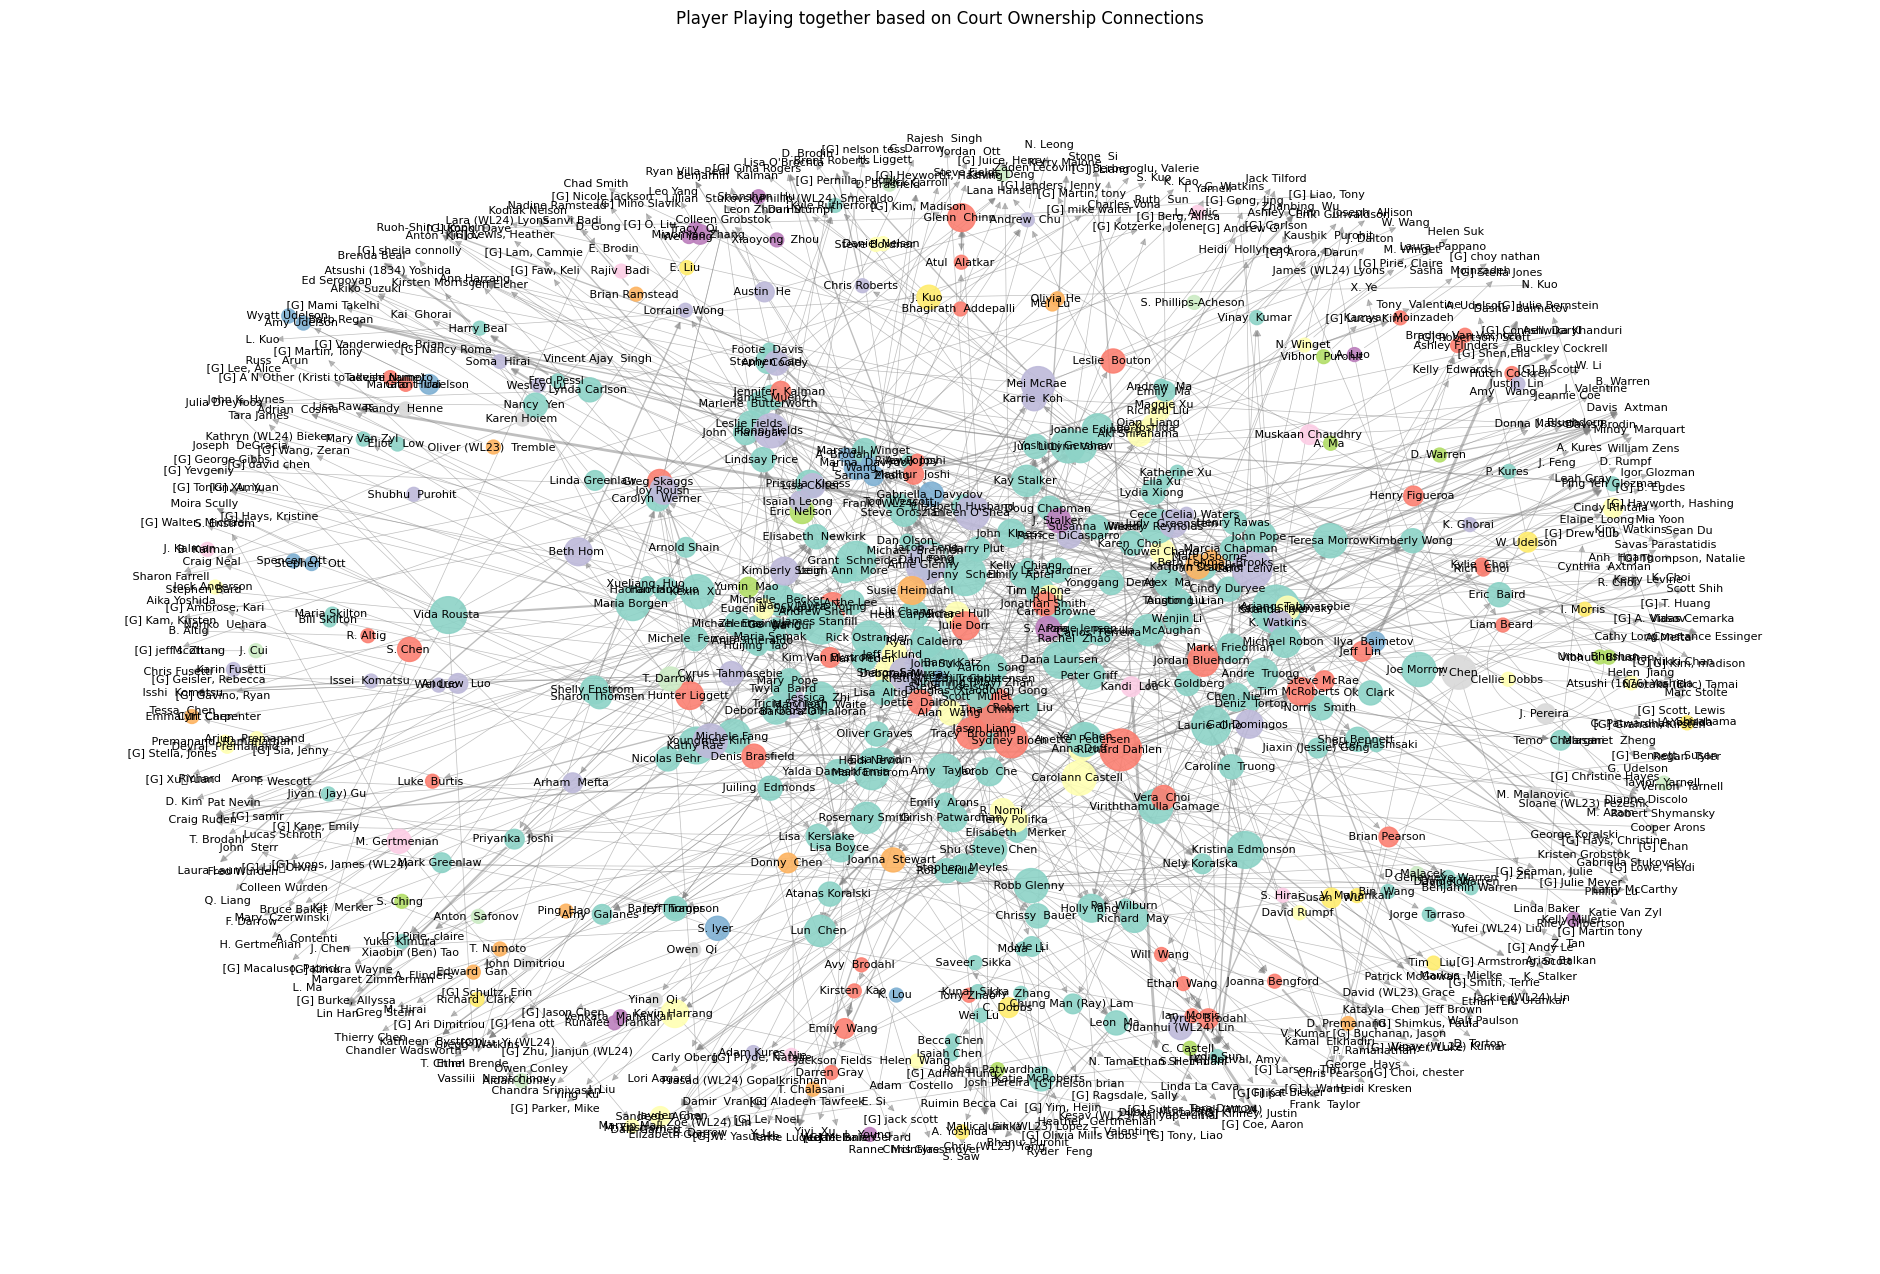

In [7]:
import networkx as nx
from matplotlib import pyplot as plt
import community as community_louvain

# Clear the previous figure
plt.clf()  # Clears the current figure
plt.close()  # Closes the figure window if it's open

# Initialize an empty directed graph
G = nx.DiGraph()

# Your graph creation code here
for _, row in df.iterrows():
    main_player = row['p1']
    other_players = [row['p2'], row['p3'], row['p4']]
    other_players = [p for p in other_players if pd.notna(p)]  # Filter out any NaN values
    
    # Create directed edges from p1 (court owner) to each non-main player
    for player in other_players:
        if G.has_edge(main_player, player):
            G[main_player][player]['weight'] += 1
        else:
            G.add_edge(main_player, player, weight=1)

# Community detection and visualization code here
partition = community_louvain.best_partition(G.to_undirected(), weight='weight')
pos = nx.spring_layout(G, seed=42)
node_sizes = [G.out_degree(node) * 100 for node in G]
clusters = [partition[node] for node in G]

plt.figure(figsize=(24, 16))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=clusters, cmap='Set3', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 0.5 for u, v in G.edges()], alpha=0.5, edge_color="grey")
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
plt.title("Player Playing together based on Court Ownership Connections")
plt.axis("off")
plt.show()


This Shows some plyers who tend to book court together (for playing with each other). 